## **Self-supervision with Barlow Twins**

In [16]:
from matplotlib import pyplot as plt 
import keras
import numpy as np
import tensorflow as tf
import math

Load CIFAR-10

In [67]:
# Load CIFAR-10 dataset 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
y_train = tf.keras.utils.to_categorical(y_train)
#y_test = tf.keras.utils.to_categorical(y_test)
print('Training set shape: ', x_train.shape)
print('Test set shape: ', x_test.shape)

BATCH_SIZE = 32

Training set shape:  (50000, 32, 32, 3)
Test set shape:  (10000, 32, 32, 3)


Define augmentation functions

In [18]:
def random_resize_crop(image, scale=[0.75, 1.0], crop_size=32):

    # Randomly crop the image on the scale given
    size = tf.random.uniform(
        shape=(1,),
        minval=scale[0] * crop_size,
        maxval=scale[1] * crop_size,
        dtype=tf.float32,
    )
    size = tf.cast(size, tf.int32)[0]
    crop = tf.image.random_crop(image, (size, size, 3))

    # Resize the crop back to the original image size
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))
    return crop_resize

def flip_random_crop(image):
    image = tf.image.random_flip_left_right(image)
    image = random_resize_crop(image, crop_size=32)
    return image

@tf.function
def float_parameter(level, maxval):
    return tf.cast(level * maxval / 10.0, tf.float32)

@tf.function
def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)


@tf.function
def solarize(image, level=6):
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 255 - image)

def color_jitter(x, strength=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength)
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength)
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    image = tf.cast(image, tf.float32)
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.9)
    image = random_apply(color_drop, image, p=0.3)
    image = random_apply(solarize, image, p=0.3)
    return image

Define the dataset views of our images

In [19]:
dataset_one = tf.data.Dataset.from_tensor_slices(x_train)
dataset_one = (
    dataset_one.shuffle(1024, seed=42)
    .map(custom_augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

dataset_two = tf.data.Dataset.from_tensor_slices(x_train)
dataset_two = (
    dataset_two.shuffle(1024, seed=42)
    .map(custom_augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

dataset_views = tf.data.Dataset.zip((dataset_one, dataset_two))

Let's check if we are getting different views of the same image

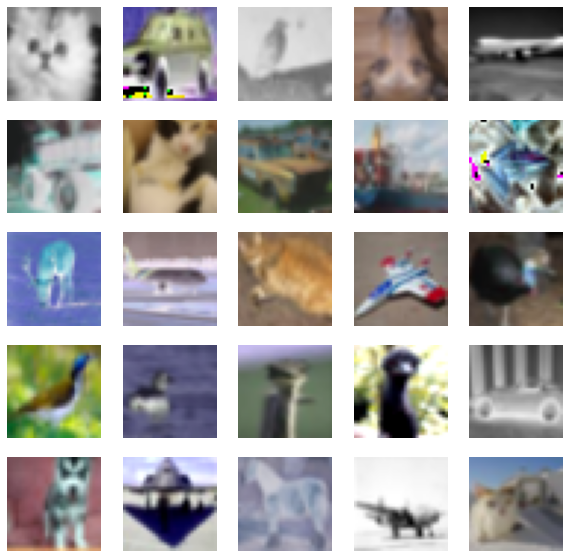

In [20]:
dataset_one = next(iter(dataset_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(dataset_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

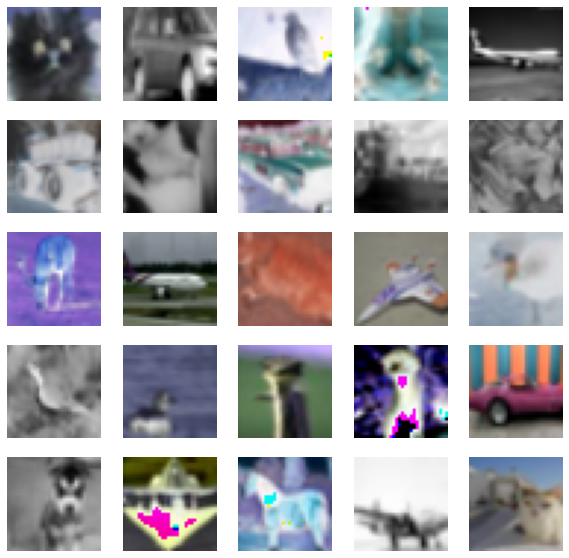

In [21]:
dataset_two = next(iter(dataset_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(dataset_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

Define BT loss

In [22]:
def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1]
    off_diagonals = tf.reshape(flattened, (n-1, n+1))[:, 1:]
    return tf.reshape(off_diagonals, [-1])

def normalize_repr(z):
    z_norm = (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)
    return z_norm


def compute_loss(z_a, z_b, lambd):
    # Get batch size and representation dimension.
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    repr_dim = tf.shape(z_a)[1]

    # Normalize the representations along the batch dimension.
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)

    # Cross-correlation matrix.
    c = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / batch_size

    # Loss.
    on_diag = tf.linalg.diag_part(c) + (-1)
    on_diag = tf.reduce_sum(tf.pow(on_diag, 2))
    off_diag = off_diagonal(c)
    off_diag = tf.reduce_sum(tf.pow(off_diag, 2))
    loss = on_diag + (lambd * off_diag)
    return loss

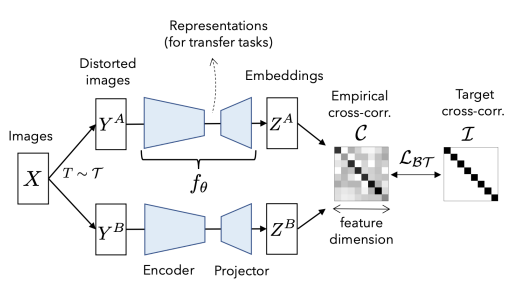

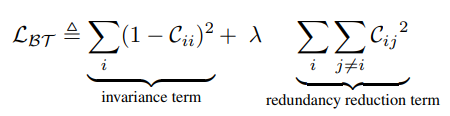

In [23]:
class BarlowTwins(tf.keras.Model):
    def __init__(self, encoder, lambd=5e-3):
        super(BarlowTwins, self).__init__()
        self.encoder = encoder
        self.lambd = lambd
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        view_one, view_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z_a, z_b = self.encoder(view_one, training=True), self.encoder(view_two, training=True)
            loss = compute_loss(z_a, z_b, self.lambd) 

        # Compute gradients and update the parameters.
        gradients = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

Train

In [25]:
def basic_model():
    
  base_model = tf.keras.applications.MobileNetV2(include_top=False, weights=None, input_shape=(32,32,3))
  
  inputs = tf.keras.layers.Input((32,32,3))
  x = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
  x = base_model(x)
  x = tf.keras.layers.GlobalAvgPool2D()(x)
 
  
  x = tf.keras.layers.Dense(512)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)

  x = tf.keras.layers.Dense(512)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)

  x = tf.keras.layers.Dense(512)(x)
  model = tf.keras.Model(inputs, x)
  return model

optimizer = tf.keras.optimizers.Adam()

model = basic_model()
barlow_twins = BarlowTwins(model)
barlow_twins.compile(optimizer=optimizer)
history = barlow_twins.fit(dataset_views, epochs=20)

Epoch 1/20
1563/1563 [==============================] - 124s 73ms/step - loss: 327.8215
Epoch 2/20
1563/1563 [==============================] - 116s 74ms/step - loss: 232.7549
Epoch 3/20
1563/1563 [==============================] - 115s 74ms/step - loss: 194.3423
Epoch 4/20
1563/1563 [==============================] - 115s 73ms/step - loss: 181.6902
Epoch 5/20
1563/1563 [==============================] - 115s 73ms/step - loss: 171.6298
Epoch 6/20
1563/1563 [==============================] - 117s 75ms/step - loss: 151.9794
Epoch 7/20
1563/1563 [==============================] - 116s 74ms/step - loss: 136.8598
Epoch 8/20
1563/1563 [==============================] - 116s 74ms/step - loss: 129.3370
Epoch 9/20
1563/1563 [==============================] - 115s 74ms/step - loss: 125.2263
Epoch 10/20
1563/1563 [==============================] - 116s 74ms/step - loss: 121.4154
Epoch 11/20
1563/1563 [==============================] - 115s 74ms/step - loss: 110.8899
Epoch 12/20
1563/1563 [=======

Let's visualize the learned features

In [26]:
# Here we will extract the 512-D layer as the feature representation
features = model.predict(x_test)
features = np.array(features)
features.shape
# Now we have the 512-D feature representation for the 10.000 images

(10000, 512)

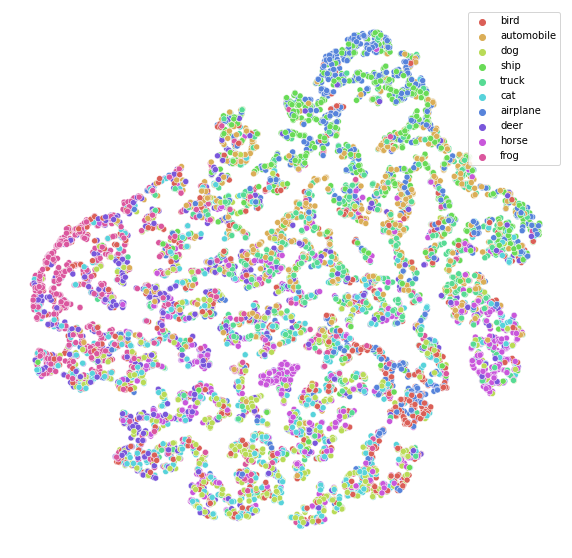

In [77]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

feat_cols = [ 'pixel'+str(i) for i in range(features.shape[1]) ]
df = pd.DataFrame(features,columns=feat_cols)
n_classes = 10
transdict = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
new_y = []
for i in range(len(y_test)):
    new_y.append(y_test[i][0])
y_train_label = np.array([transdict[x] for x in new_y])
df['y'] = y_train_label
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(features)
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(10,10))
sns_tsne_plot = sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue="y",
            palette=sns.color_palette("hls", n_classes),
            data=df.loc[rndperm,:],
            legend='full',
            alpha=1.0
            
)
plt.axis('off')
plt.legend(fontsize='medium', loc='upper right')
plt.show()

Without training

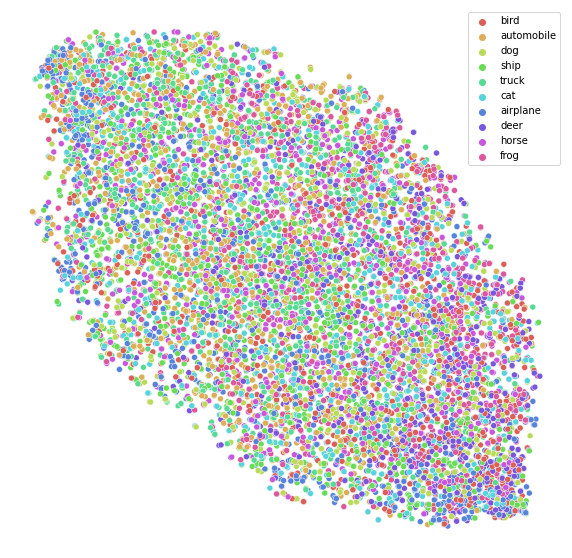

In [78]:
model2 = basic_model()
# Here we will extract the 512-D layer as the feature representation
features2 = model2.predict(x_test)
features2 = np.array(features2)
features2.shape
# Now we have the 512-D feature representation for the 10.000 images

feat_cols = [ 'pixel'+str(i) for i in range(features2.shape[1]) ]
df = pd.DataFrame(features2,columns=feat_cols)
n_classes = 10
transdict = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
new_y = []
for i in range(len(y_test)):
    new_y.append(y_test[i][0])
y_train_label = np.array([transdict[x] for x in new_y])
df['y'] = y_train_label
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(features2)
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(10,10))
sns_tsne_plot = sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue="y",
            palette=sns.color_palette("hls", n_classes),
            data=df.loc[rndperm,:],
            legend='full',
            alpha=1.0
            
)
plt.axis('off')
plt.legend(fontsize='medium', loc='upper right')
plt.show()